In [1]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

warnings.filterwarnings('ignore')

In [2]:
# with only BluesCountryElectronicFolkJazzMetalPopReggaeRockRap genres
data = pd.read_csv(f'../GeneratedData/3secondsData/BluesCountryElectronicFolkJazzMetalPopReggaeRockRap_Dataset.csv')
data = data.iloc[0:, 1:] 
data.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,filename,Genre,TrackID,label
0,0.321116,0.095008,0.185607,0.004235,2309.576775,9.303002e+04,2429.792516,51723.402280,4856.648325,4.736177e+05,...,2.510336,56.786434,-0.214017,58.317300,6.080600,91.186195,Blues-TRCRAIR128F935713E-9,Blues,TRCRAIR128F935713E,Blues
1,0.427229,0.084437,0.158308,0.001943,2470.299940,1.150638e+06,2433.543715,147715.927307,5104.445801,2.473978e+06,...,-3.635559,31.478884,-3.941624,30.230938,1.690726,40.746650,Blues-TRACOHF128F1498509-3,Blues,TRACOHF128F1498509,Blues
2,0.296744,0.079636,0.192385,0.001355,1455.887998,8.621976e+04,2057.615196,44640.975001,2814.886569,6.749792e+05,...,-0.703013,21.415850,-2.639422,18.214354,3.585274,27.473557,Blues-TRIUACN128F9333554-4,Blues,TRIUACN128F9333554,Blues
3,0.434301,0.071975,0.329864,0.001105,3050.314322,8.716237e+04,2837.614893,22244.267512,6540.047889,3.615928e+05,...,4.611008,43.104730,-1.767525,43.300310,0.050157,35.812057,Blues-TRUWCUD12903CD4501-1,Blues,TRUWCUD12903CD4501,Blues
4,0.342937,0.081494,0.366179,0.001296,1649.309448,5.753548e+04,2179.496962,57149.244176,3387.172852,5.985052e+05,...,2.774094,26.795692,-7.628335,17.076103,1.692927,20.737106,Blues-TRURGHT12903CB7583-5,Blues,TRURGHT12903CB7583,Blues


In [3]:
y = data['label'] # genre variable.
X = data.drop(columns=['label','TrackID','Genre','filename']) #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

30% Testing Data, 70% Training Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Accuracy of models

def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

Accuracy Naive Bayes : 0.27463 

Accuracy Stochastic Gradient Descent : 0.30326 

Accuracy KNN : 0.58589 

Accuracy Decission trees : 0.37683 

Accuracy Random Forest : 0.53628 

Accuracy Support Vector Machine : 0.38349 

Accuracy Logistic Regression : 0.35087 



In [ ]:
# Testing more models

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Fit and transform y_train and y_test
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

def model_assess_encoded(model, X_train, y_train, X_test, y_test, title="Default"):
    # Train model with encoded labels
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_decoded = le.inverse_transform(preds)
    print(f"{title} - Accuracy:", round(accuracy_score(y_test, preds), 5))

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess_encoded(xgb, X_train, y_train_encoded, X_test, y_test_encoded, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess_encoded(xgbrf, X_train, y_train_encoded, X_test, y_test_encoded, "Cross Gradient Booster (Random Forest)")

Cross Gradient Booster - Accuracy: 0.68472
Cross Gradient Booster (Random Forest) - Accuracy: 0.40875


Accuracy : 0.68472 



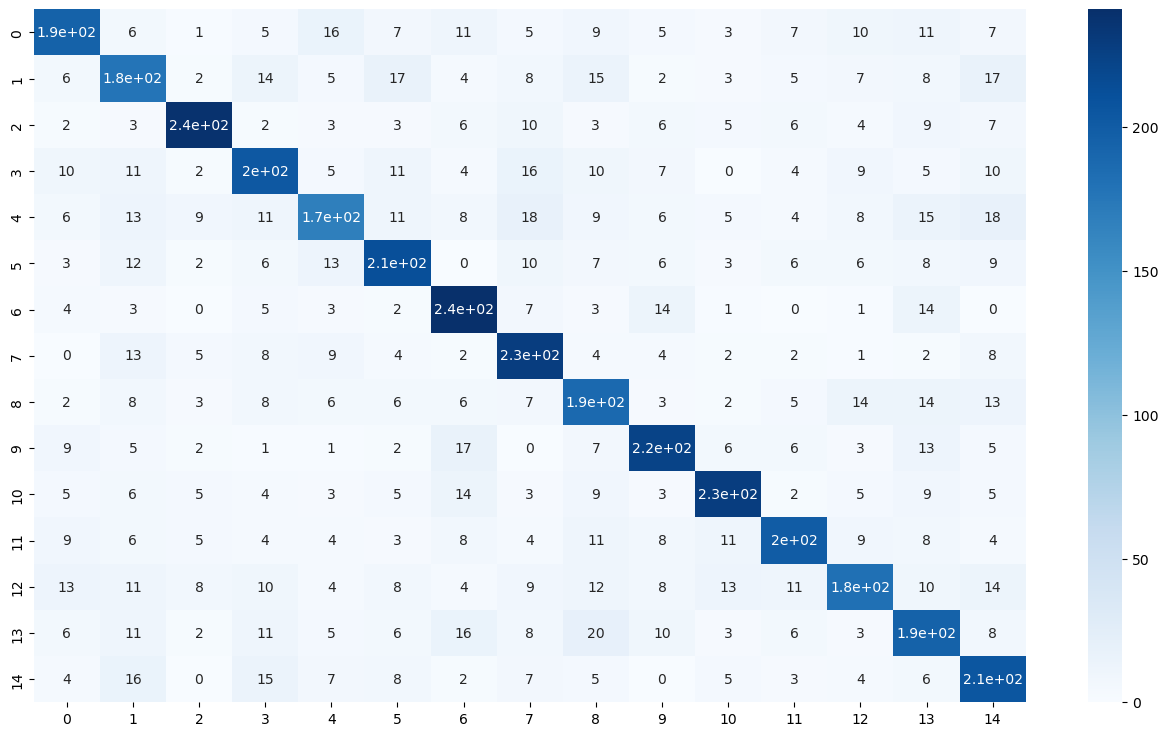

In [13]:
# Final model, XGB had best accuracy
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train_encoded)


preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test_encoded, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test_encoded, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True) 
plt.savefig("conf matrix")
plt.show()